In [1]:
pip install medmnist

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
Using cached termcolor-2.5.0-py3-none-any.whl (7.8 kB)
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114349 sha256=cfc7a507f2af36f9a83f41c4cf3a093f6838d3049805e60a307661e3a8ae33bb
  Stored in directory: c:\users\12905\appdata\local\pip\cache\wheels\9e\5b\45\29f72e55d87a29426b04b3cfdf20325c079eb97ab74f59017d
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


## Task 1

Using downloaded and verified file: C:\Users\12905\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\12905\.medmnist\bloodmnist.npz
Train samples: 11959, Test samples: 3421


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21148455..1.6631372].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28151262..1.6544228].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28151262..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3602941..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.062675..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39530808..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.316

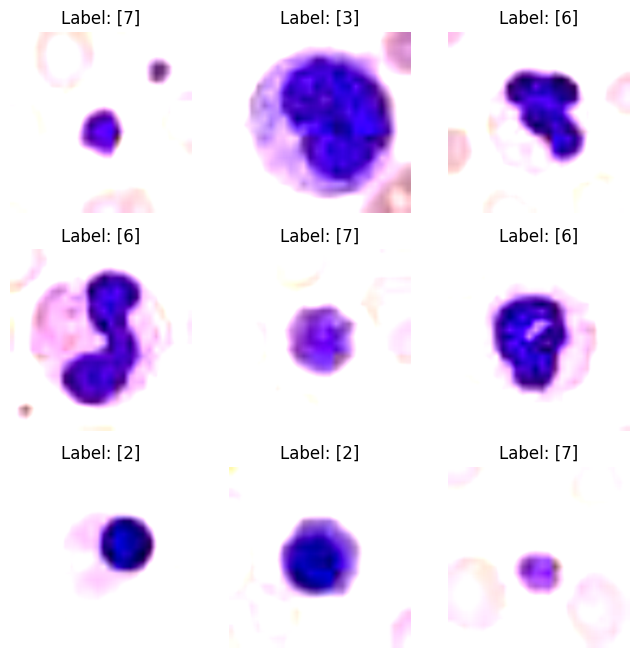

Epoch [1/25] | Loss: 1.2789 | Accuracy: 0.5042 | Val Loss: 0.7963 | Val Accuracy: 0.6945
Epoch [2/25] | Loss: 0.8094 | Accuracy: 0.7046 | Val Loss: 0.6986 | Val Accuracy: 0.7477
Epoch [3/25] | Loss: 0.6767 | Accuracy: 0.7519 | Val Loss: 0.5942 | Val Accuracy: 0.7922
Epoch [4/25] | Loss: 0.5931 | Accuracy: 0.7878 | Val Loss: 0.4852 | Val Accuracy: 0.8354
Epoch [5/25] | Loss: 0.5293 | Accuracy: 0.8087 | Val Loss: 0.4919 | Val Accuracy: 0.8226
Epoch [6/25] | Loss: 0.4990 | Accuracy: 0.8231 | Val Loss: 0.5069 | Val Accuracy: 0.8465
Epoch [7/25] | Loss: 0.4728 | Accuracy: 0.8292 | Val Loss: 0.4532 | Val Accuracy: 0.8460
Epoch [8/25] | Loss: 0.4486 | Accuracy: 0.8420 | Val Loss: 0.4592 | Val Accuracy: 0.8436
Epoch [9/25] | Loss: 0.4170 | Accuracy: 0.8563 | Val Loss: 0.5337 | Val Accuracy: 0.8401
Epoch [10/25] | Loss: 0.4550 | Accuracy: 0.8418 | Val Loss: 0.4693 | Val Accuracy: 0.8442
Epoch [11/25] | Loss: 0.4086 | Accuracy: 0.8622 | Val Loss: 0.4809 | Val Accuracy: 0.8483
Epoch [12/25] | Los

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import BloodMNIST
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


    #same as Professor provided code
transform = transforms.Compose([
    #change to 224,since vgg 16 input size is 224 and rgb 3 channel, so i didn't modify to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # for vgg-16, we neeed change the normalization to imageNet one
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    
])
train_dataset = BloodMNIST(split="train", transform=transform, download=True)
test_dataset = BloodMNIST(split="test", transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


def get_vgg16_model():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        # BloodMNIST has 8 classes, so change to 8
        nn.Linear(256, 8),
        nn.Softmax(dim=1)
    )

    return model



def train_model(model, train_loader, test_loader, epochs=25, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # mention we should use cross entropy
    criterion = nn.CrossEntropyLoss()
    # use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).squeeze().long()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Compute training accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        
        train_accuracy = correct / total
        
        # Validation loss and accuracy
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device).squeeze().long()
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                predictions = torch.argmax(outputs, dim=1)
                correct_val += (predictions == labels).sum().item()
                total_val += labels.size(0)
        
        val_accuracy = correct_val / total_val
        
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {train_accuracy:.4f} | Val Loss: {val_loss/len(test_loader):.4f} | Val Accuracy: {val_accuracy:.4f}")
    
    torch.save(model.state_dict(), "vgg16_bloodmnist.pth")
    print("Model saved.")


def evaluate_model(model, test_loader):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).squeeze().long()
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred, average='macro'):.4f}")


def visualize_samples(dataset):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(9):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format for display
        img = (img * 0.5) + 0.5  # Unnormalize
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

if __name__ == "__main__":
    visualize_samples(train_dataset)
    model = get_vgg16_model()
    train_model(model, train_loader, test_loader, epochs=25, lr=0.001)
    evaluate_model(model, test_loader)


## Task 2 - erosion and opening 

In [1]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from medmnist import BloodMNIST
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),                        
    transforms.Normalize(mean=[0.5], std=[0.5])  
])


se = np.ones((3, 3), np.uint8)  

class FractureMNIST_Morph1(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        img = img.numpy().squeeze()  
        img = ((img * 0.5) + 0.5) * 255 
        img = img.astype(np.uint8) 
        img = cv2.erode(img, se, iterations=1)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0  
        return img, label


train_base_dataset = BloodMNIST(split="train", transform=transform, download=True)
test_base_dataset = BloodMNIST(split="test", transform=transform, download=True)

train_dataset_Experiment1 = FractureMNIST_Morph1(train_base_dataset)
test_dataset_Experiment1 = FractureMNIST_Morph1(test_base_dataset)

train_loader1 = DataLoader(train_dataset_Experiment1, batch_size=32, shuffle=True)
test_loader1 = DataLoader(test_dataset_Experiment1, batch_size=32, shuffle=False)
print(f"FractureMNIST_Morph1 - Train samples: {len(train_dataset_Experiment1)}, Test samples: {len(test_dataset_Experiment1)}")


Using downloaded and verified file: C:\Users\12905\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\12905\.medmnist\bloodmnist.npz
FractureMNIST_Morph1 - Train samples: 11959, Test samples: 3421


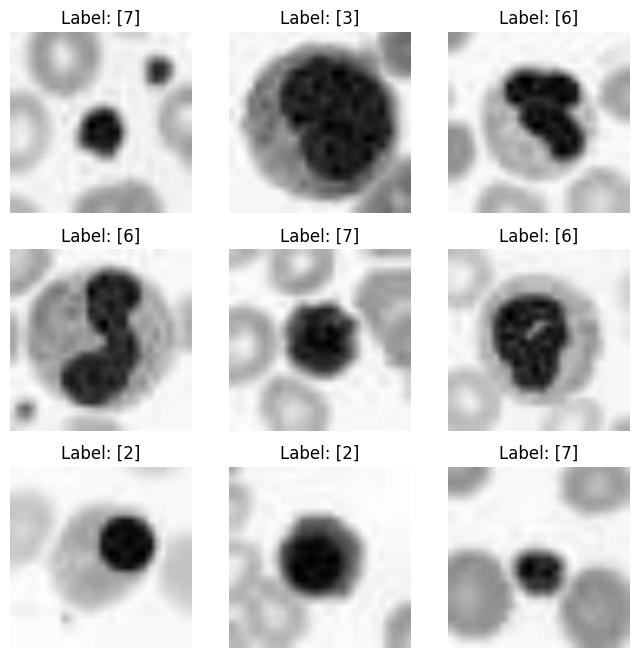

In [2]:
import matplotlib.pyplot as plt

def visualize_samples(dataset):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(9):
        img, label = dataset[i]
        img = img.squeeze(0).numpy()
        img = (img * 0.5) + 0.5 
        ax = axes[i // 3, i % 3]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

visualize_samples(train_dataset_Experiment1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np


def get_vgg16_model():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 8),
        nn.Softmax(dim=1)
    )
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_vgg16_model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 25

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader1:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze().long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader1)
    train_accuracy = correct_train / total_train

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader1:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze().long()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader1)
    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

# Final Model Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader1:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze().long()
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)

print(f"\nFinal Test Accuracy: {accuracy:.4f}")


Epoch [1/25] | Loss: 0.7350 | Accuracy: 0.7346 | Val Loss: 0.4135 | Val Accuracy: 0.8576
Epoch [2/25] | Loss: 0.4250 | Accuracy: 0.8526 | Val Loss: 0.3851 | Val Accuracy: 0.8705
Epoch [3/25] | Loss: 0.3288 | Accuracy: 0.8875 | Val Loss: 0.2689 | Val Accuracy: 0.9132
Epoch [4/25] | Loss: 0.2592 | Accuracy: 0.9125 | Val Loss: 0.2567 | Val Accuracy: 0.9187
Epoch [5/25] | Loss: 0.2002 | Accuracy: 0.9321 | Val Loss: 0.2650 | Val Accuracy: 0.9220
Epoch [6/25] | Loss: 0.1680 | Accuracy: 0.9410 | Val Loss: 0.2321 | Val Accuracy: 0.9284
Epoch [7/25] | Loss: 0.1456 | Accuracy: 0.9509 | Val Loss: 0.2476 | Val Accuracy: 0.9152
Epoch [8/25] | Loss: 0.1277 | Accuracy: 0.9579 | Val Loss: 0.2616 | Val Accuracy: 0.9228
Epoch [9/25] | Loss: 0.1009 | Accuracy: 0.9647 | Val Loss: 0.2698 | Val Accuracy: 0.9199
Epoch [10/25] | Loss: 0.0777 | Accuracy: 0.9744 | Val Loss: 0.4206 | Val Accuracy: 0.8837
Epoch [11/25] | Loss: 0.0780 | Accuracy: 0.9737 | Val Loss: 0.2468 | Val Accuracy: 0.9278
Epoch [12/25] | Los

In [4]:
torch.save(model.state_dict(), "vgg16_bloodmnist_erode.pth")
print("Model saved.")

Model saved.


In [9]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from medmnist import BloodMNIST
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
    

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),                        
    transforms.Normalize(mean=[0.5], std=[0.5])  
])


se = np.ones((3, 3), np.uint8)  

class FractureMNIST_Morph2(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        img = img.numpy().squeeze()  
        img = ((img * 0.5) + 0.5) * 255 
        img = img.astype(np.uint8) 
        # change to opening
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN,se)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0  
        return img, label


train_base_dataset = BloodMNIST(split="train", transform=transform, download=True)
test_base_dataset = BloodMNIST(split="test", transform=transform, download=True)

train_dataset_Experiment2 = FractureMNIST_Morph2(train_base_dataset)
test_dataset_Experiment2 = FractureMNIST_Morph2(test_base_dataset)

train_loader2 = DataLoader(train_dataset_Experiment2, batch_size=32, shuffle=True)
test_loader2 = DataLoader(test_dataset_Experiment2, batch_size=32, shuffle=False)
print(f"FractureMNIST_Morph2 - Train samples: {len(train_dataset_Experiment2)}, Test samples: {len(test_dataset_Experiment2)}")


Using downloaded and verified file: C:\Users\12905\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\12905\.medmnist\bloodmnist.npz
FractureMNIST_Morph2 - Train samples: 11959, Test samples: 3421


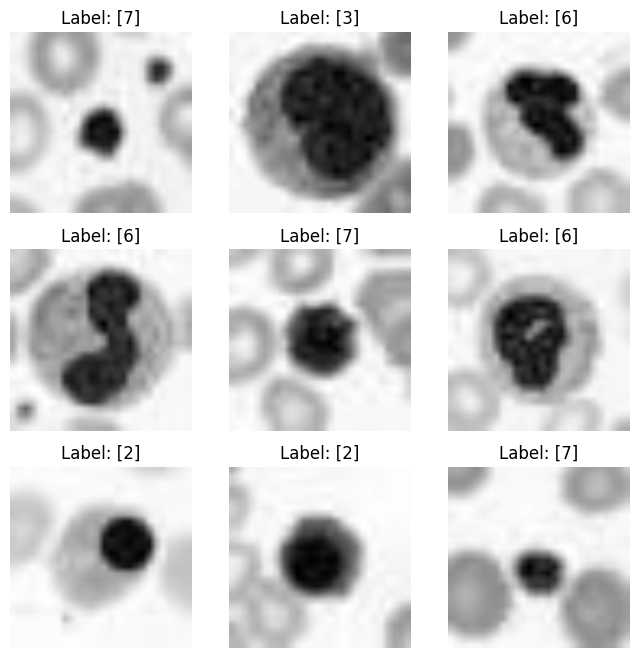

In [10]:
import matplotlib.pyplot as plt

def visualize_samples(dataset):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(9):
        img, label = dataset[i]
        img = img.squeeze(0).numpy()
        img = (img * 0.5) + 0.5 
        ax = axes[i // 3, i % 3]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

visualize_samples(train_dataset_Experiment2)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np


def get_vgg16_model():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 8)
    )
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_vgg16_model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 25

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader2:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze().long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader2)
    train_accuracy = correct_train / total_train

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader2:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze().long()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader2)
    val_accuracy = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

# Final Model Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader2:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze().long()
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)

print(f"\nFinal Test Accuracy: {accuracy:.4f}")


Epoch [1/25] | Loss: 0.7877 | Accuracy: 0.7139 | Val Loss: 0.4577 | Val Accuracy: 0.8433
Epoch [2/25] | Loss: 0.4642 | Accuracy: 0.8350 | Val Loss: 0.3981 | Val Accuracy: 0.8579
Epoch [3/25] | Loss: 0.3703 | Accuracy: 0.8716 | Val Loss: 0.3264 | Val Accuracy: 0.8834
Epoch [4/25] | Loss: 0.3067 | Accuracy: 0.8901 | Val Loss: 0.2677 | Val Accuracy: 0.9103
Epoch [5/25] | Loss: 0.2547 | Accuracy: 0.9103 | Val Loss: 0.3039 | Val Accuracy: 0.8959
Epoch [6/25] | Loss: 0.1986 | Accuracy: 0.9312 | Val Loss: 0.2835 | Val Accuracy: 0.9068
Epoch [7/25] | Loss: 0.1784 | Accuracy: 0.9401 | Val Loss: 0.2571 | Val Accuracy: 0.9123
Epoch [8/25] | Loss: 0.1472 | Accuracy: 0.9503 | Val Loss: 0.2323 | Val Accuracy: 0.9284
Epoch [9/25] | Loss: 0.1292 | Accuracy: 0.9558 | Val Loss: 0.2271 | Val Accuracy: 0.9272
Epoch [10/25] | Loss: 0.1096 | Accuracy: 0.9630 | Val Loss: 0.3617 | Val Accuracy: 0.8959
Epoch [11/25] | Loss: 0.0812 | Accuracy: 0.9709 | Val Loss: 0.2866 | Val Accuracy: 0.9211
Epoch [12/25] | Los

In [12]:
torch.save(model.state_dict(), "vgg16_bloodmnist_open.pth")
print("Model saved.")

Model saved.


## Task3

In [ ]:
import cv2

    #same as Professor provided code
transform = transforms.Compose([
    #change to 224,since vgg 16 input size is 224 and rgb 3 channel, so i didn't modify to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # for vgg-16, we neeed change the normalization to imageNet one
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    
])
train_dataset = BloodMNIST(split="train", transform=transform, download=True)
test_dataset = BloodMNIST(split="test", transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

C:\Users\12905\AppData\Local\Temp\ipykernel_44536\3269026862.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

                Task  Accuracy  Precision    Recall  F1-score
0         Raw Images  0.402222   0.512685  0.402222  0.318992
1  Erosion Processed  0.926045   0.930398  0.926045  0.926955
2  Opening Processed  0.927799   0.929249  0.927799  0.927738


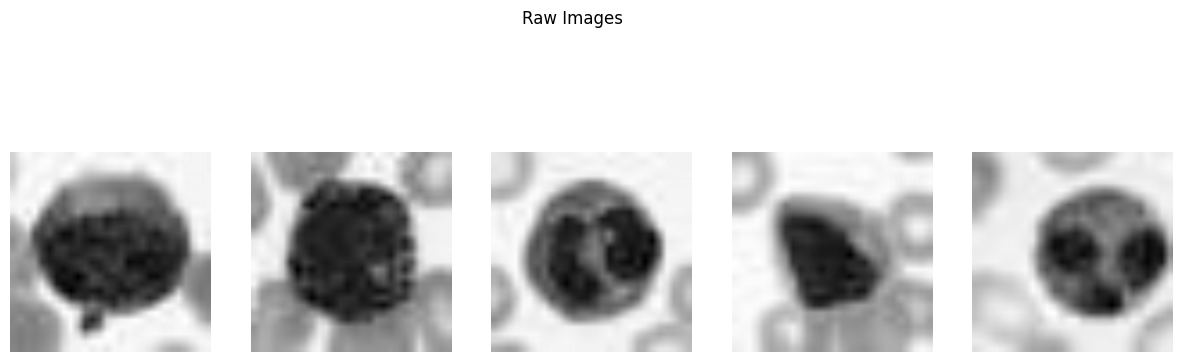

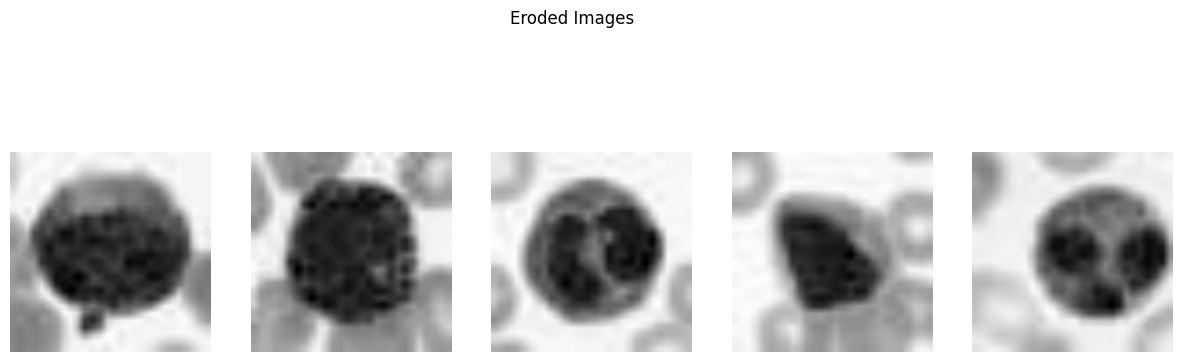

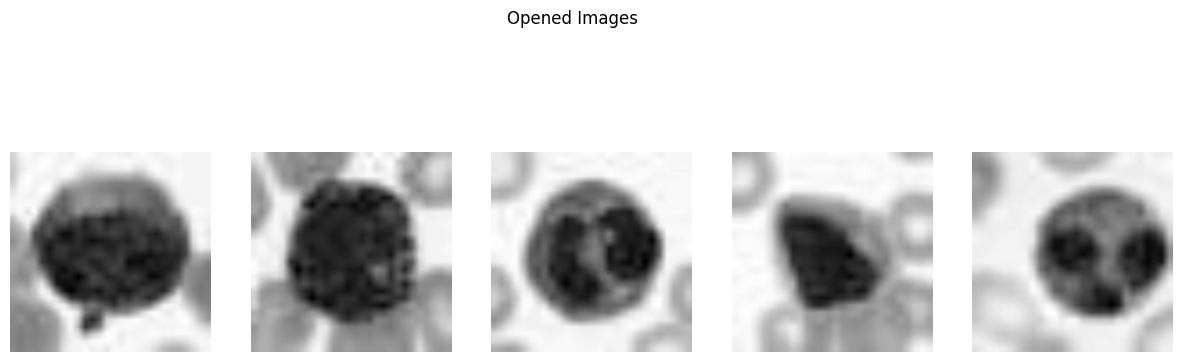

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..1.0].


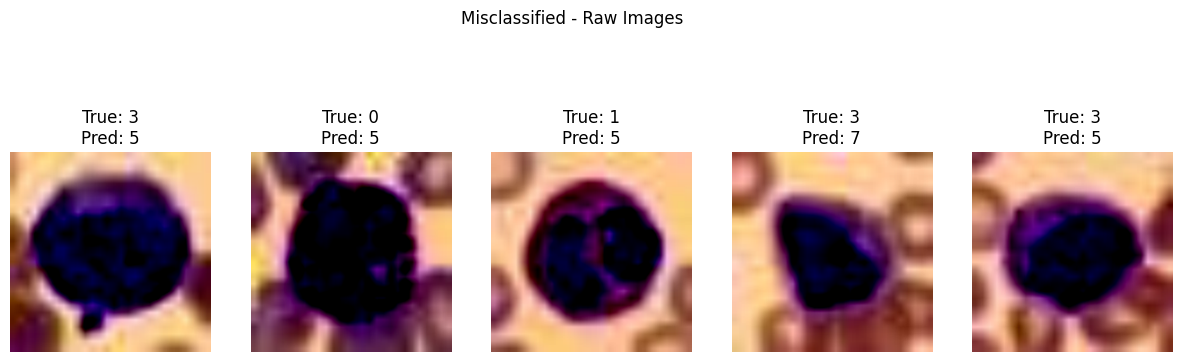

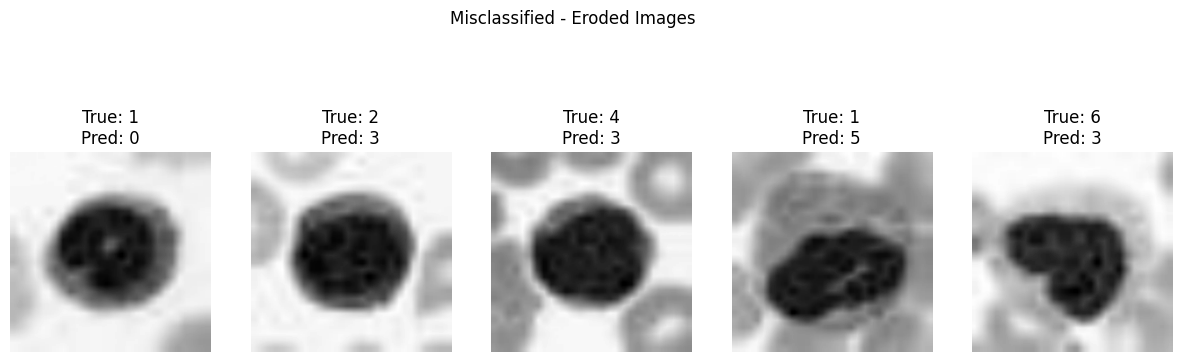

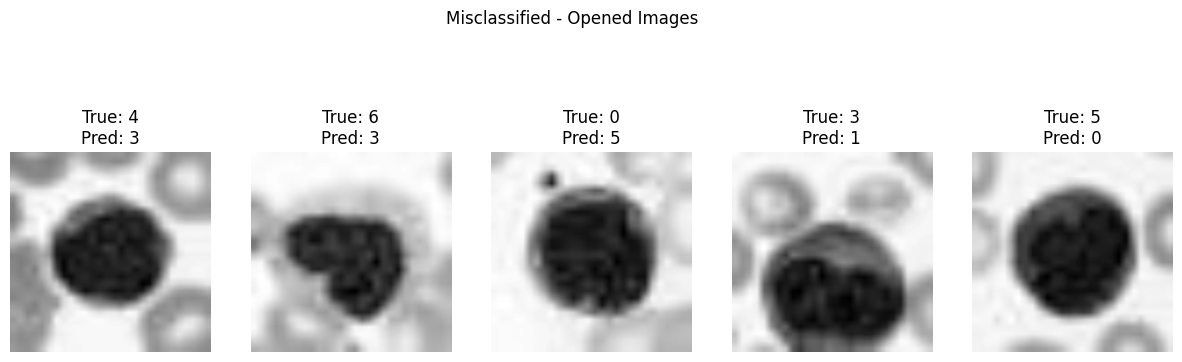

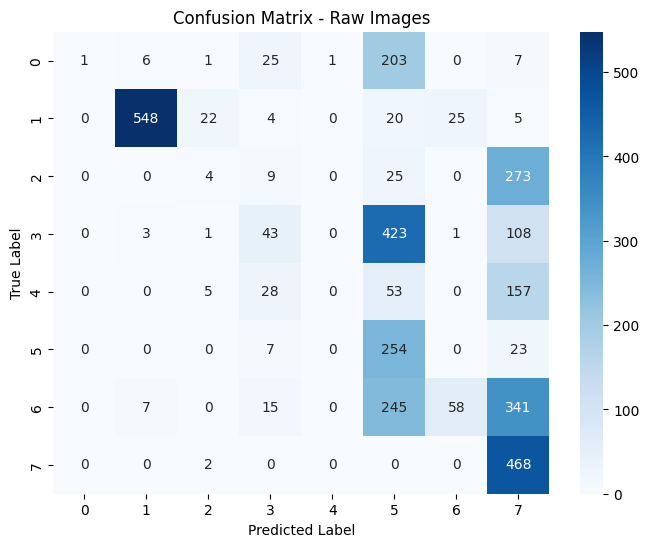

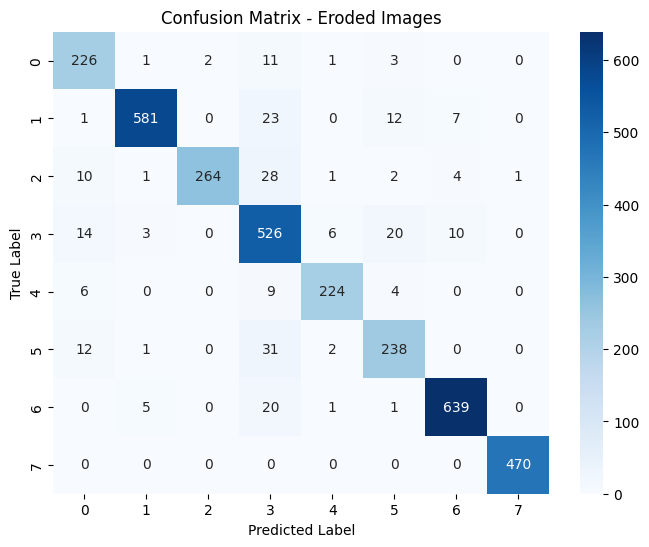

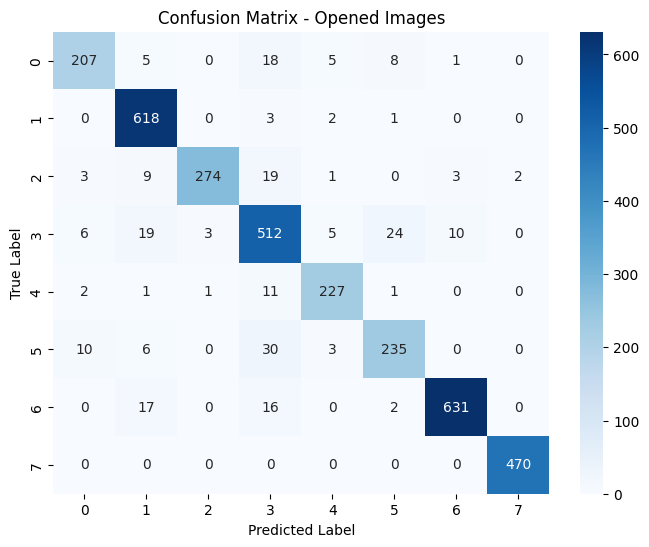

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torchvision.transforms as transforms
import cv2


def load_model(model_path, model_type="original"):
    if model_type == "original":
        model = get_vgg16_model_original()
    else:
        model = get_vgg16_model_grayscale()  # For "open" and "erode"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def get_vgg16_model_original():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 8)
    )
    return model

def get_vgg16_model_grayscale():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Change input channels to 1
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 8)
    )
    return model

# Evaluate model function
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return accuracy, precision, recall, f1, all_labels, all_preds

# Original Model (RGB)
model_raw = load_model("vgg16_bloodmnist.pth", model_type="original")

# Erosion Model (Grayscale)
model_erode = load_model("vgg16_bloodmnist_erode.pth", model_type="grayscale")

# Opening Model (Grayscale)
model_open = load_model("vgg16_bloodmnist_open.pth", model_type="grayscale")

# Evaluate models
acc_raw, prec_raw, rec_raw, f1_raw, labels_raw, preds_raw = evaluate_model(model_raw, test_loader)
acc_erode, prec_erode, rec_erode, f1_erode, labels_erode, preds_erode = evaluate_model(model_erode, test_loader1)
acc_open, prec_open, rec_open, f1_open, labels_open, preds_open = evaluate_model(model_open, test_loader2)

# Results Table
results = {
    "Task": ["Raw Images", "Erosion Processed", "Opening Processed"],
    "Accuracy": [acc_raw, acc_erode, acc_open],
    "Precision": [prec_raw, prec_erode, prec_open],
    "Recall": [rec_raw, rec_erode, rec_open],
    "F1-score": [f1_raw, f1_erode, f1_open]
}

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


def show_preprocessing_examples(dataset, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    axs = axs.flatten()

    for i in range(5):
        img, _ = dataset[i]
        img = img.squeeze().numpy()
        
        if img.ndim == 3:  # If it's an RGB image
            img = cv2.cvtColor(img.transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)  # Convert to grayscale

        axs[i].imshow(img, cmap="gray")
        axs[i].axis("off")
    
    plt.suptitle(title)
    plt.show()

show_preprocessing_examples(test_dataset, "Raw Images")
show_preprocessing_examples(test_dataset_Experiment1, "Eroded Images")
show_preprocessing_examples(test_dataset_Experiment2, "Opened Images")

# Show misclassified images
import cv2

def show_misclassified_images(test_loader, model, title):
    model.eval()  # Set the model to evaluation mode
    misclassified = []

    # Iterate through the test loader
    with torch.no_grad():  # Disable gradient computation for inference
        for img, label in test_loader:
            img = img.cuda()  # Move the image to the GPU if using CUDA
            label = label.cuda()  # Move labels to the GPU if necessary

            # Get model predictions
            output = model(img)
            _, pred = torch.max(output, 1)  # Get the predicted class

            # Find misclassified samples
            for j in range(len(label)):
                if pred[j] != label[j]:  # If prediction is wrong, store the image and labels
                    misclassified.append((img[j], label[j].item(), pred[j].item()))  # Add img, true label, predicted label

    # Plot misclassified images
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    axs = axs.flatten()

    for i, (img, label, pred) in enumerate(misclassified[:5]):  # Limit to 5 misclassified images for display
        img = img.squeeze().cpu().numpy()  # Convert to NumPy array (move to CPU and remove singleton dim)
        
        if img.ndim == 3:  # If it's an RGB image
            img = img.transpose(1, 2, 0)  # Convert to HWC format for displaying

        # Display the image
        axs[i].imshow(img, cmap="gray")  # Grayscale or RGB depending on the data
        axs[i].set_title(f"True: {label}\nPred: {pred}")
        axs[i].axis("off")
    
    plt.suptitle(title)
    plt.show()
show_misclassified_images(test_loader, model_raw, "Misclassified - Raw Images")
show_misclassified_images(test_loader1, model_erode, "Misclassified - Eroded Images")
show_misclassified_images(test_loader2, model_open, "Misclassified - Opened Images")

# Plot Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(8), yticklabels=range(8))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(labels_raw, preds_raw, "Confusion Matrix - Raw Images")
plot_confusion_matrix(labels_erode, preds_erode, "Confusion Matrix - Eroded Images")
plot_confusion_matrix(labels_open, preds_open, "Confusion Matrix - Opened Images")
